# Сравнение разностных схем при базовом режиме (скорость постоянная)

Этот фрагмент выполняет трёхмерное сравнение трёх разностных схем (явная, неявная и Кранк-Николсон) при трёх разных длинах трубы (1000, 1500 и 2000 м) и строит для каждого сочетания 3D-поверхность `T(x,t)`.

---

## 1. Геометрия и физика  
- Фиксируются константы: температуры (`T_env`, `T_in`), термодиффузия `α`, потери `β_env`, время расчёта `τ`.  
- Задаётся равномерный профиль скорости `v_const`.

## 2. Вспомогательные функции  
- **`pick_dt(dx, v)`**  
  Вычисляет устойчивый шаг по времени (для явного метода) или «комфортный» шаг для неявных схем.  
- **`build_matrix(a, b, c)`**  
  Формирует ленточную матрицу (формат `solve_banded`) для решения тридиагональной системы.  
- **`scheme_name(code)`**  
  Переводит код схемы (`"FTCS"`, `"BE"`, `"CN"`) в человекочитаемый заголовок.

## 3. Решатель `solve_heat(L, v, scheme)`  
1. Строит пространственно-временную сетку по длине `L` и шагам `Δx`, `Δt`.  
2. Рассчитывает и сохраняет массив температур `T[n+1,i]` от явной аппроксимации или от решения тридиагональной системы по формуле:  
   - **Явная**: прямой апдейт конвекции, диффузии и теплопотерь.  
   - **Неявная и смешанная**: формирует явную часть `(1−θ)` и решает неявную `(θ)` через метод прогонки.  
3. Накладывает граничные условия:  
   - `T(0,t) = T_in` (Дирихле)  
   - `∂T/∂x|_{x=L} = 0` (изолированный торец, Неймана)

## 4. Сбор результатов  
- В двойном цикле по трём длинам (1000, 1500, 2000 м) и трём схемам вызывается `solve_heat`.  
- Сохраняются тройки массивов `(x, t, T)` для последующей визуализации.

## 5. Визуализация  
- На единой фигуре с сеткой 3×3 строится поверхность `T(x,t)` для каждого варианта.  
- Каждый подграфик подписан: название схемы и длина трубы.  
- Настроены оси `x (м)`, `t (ч)`, `T (K)` и единый диапазон `z` для всех.

---

**Результат:**  
Наглядная демонстрация того, как выбор численной схемы влияет на распределение температуры во времени и по длине трубы, при прочих равных условиях.  


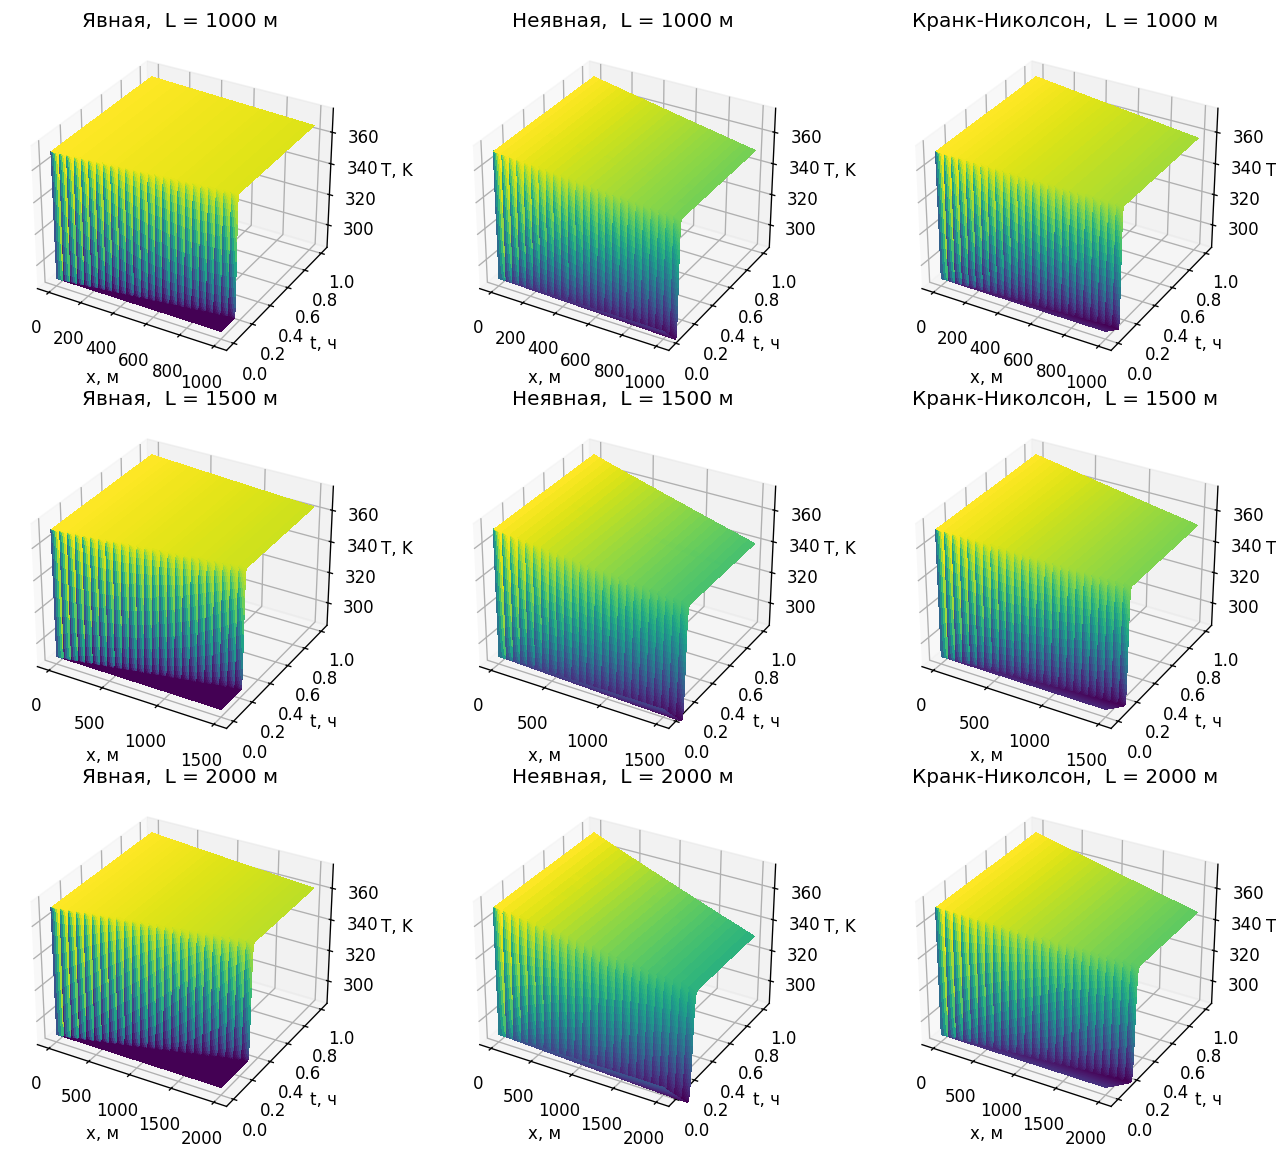

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.dpi'] = 120

# ---------- 0. физика и константы ------------------------------
T_ENV, T_IN = 290.0, 370.0          # K
rho, cp, k  = 1000.0, 4186.0, 0.6
alpha       = k/(rho*cp)            # м²/с
beta_env    = 1.0e-4                # 1/с
tau         = 3600.0               # [c] — 1 ч
v_const     = 1.8                   # м/с (одинаковая для всех L)
lengths     = [1_000, 1_500, 2_000] # м

# ---------- 1. вспомогательные функции -------------------------
def pick_dt(dx, v):
    return 0.8*min(dx*dx/(2*alpha), dx/max(v, 1e-6))

def build_matrix(N, r, s, theta):
    a = theta*(  r + s/2)
    c = theta*(  r - s/2)
    b = 1 + theta*(2*r + beta_env*dt)

    ab         = np.zeros((3, N))
    ab[0, 1:]  = -c              # над-диагональ
    ab[1, :]   =  b              # главная диагональ
    ab[2, :-1] = -a              # под-диагональ
    return ab, a, c

def scheme_name(code):
    return {"FTCS":"Явная", "BE":"Неявная", "CN":"Кранк-Николсон"}[code]

# ---------- 2. решатель ----------------------------------------
def solve_heat(L, v, scheme="FTCS"):
    # сетка
    Nx       = 300
    x        = np.linspace(0, L, Nx+1)
    dx       = x[1]-x[0]
    global dt; dt = pick_dt(dx, v)
    Nt       = int(np.ceil(tau/dt))
    t        = np.linspace(0, Nt*dt, Nt+1)

    # коэффициенты
    r = alpha*dt/dx**2
    s = v*dt/dx

    # контейнер температур
    T = np.full((Nt+1, Nx+1), T_ENV)
    T[:, 0] = T_IN     # граничное условие на входе

    # параметры схемы
    theta = {"FTCS":0.0, "BE":1.0, "CN":0.5}[scheme]

    # пред-собранная ленточная матрица
    if scheme != "FTCS":
        Ab, a, c = build_matrix(Nx-1, r, s, theta)   # Nx-1 внутренних узлов

    # итерация по времени
    for n in range(Nt):
        if scheme == "FTCS":                   # ─── ЯВНАЯ  (θ = 0)
            Tn          = T[n]
            conv        = -s*(Tn[1:-1] - Tn[:-2])
            diff        =  r*(Tn[2:]  - 2*Tn[1:-1] + Tn[:-2])
            loss        = -beta_env*dt*(Tn[1:-1]-T_ENV)
            T[n+1,1:-1] = Tn[1:-1] + conv + diff + loss

        else:                                  # НЕЯВНАЯ ИЛИ СМЕШЕННАЯ
            # правая часть
            Tn   = T[n]
            conv = -s*(Tn[1:-1] - Tn[:-2])
            diff =  r*(Tn[2:]  - 2*Tn[1:-1] + Tn[:-2])
            loss = -beta_env*dt*(Tn[1:-1]-T_ENV)
            RHS  = Tn[1:-1] + (1-theta)*(conv + diff + loss)

            # учёт граничных условий
            RHS[0]  += a * T_IN          # левая граница (Дирихле)
            RHS[-1] += c * Tn[-1]        # правая — тепловой поток = 0

            # решение СЛАУ для нового слоя
            T[n+1,1:-1] = solve_banded((1,1), Ab, RHS)

        # правая граница
        T[n+1,-1] = T[n+1,-2]

    return x, t/3600, T

# ---------- 3. запускаем все схемы и длины ---------------------
results = []
for L in lengths:
    for code in ("FTCS", "BE", "CN"):
        x, t, T = solve_heat(L, v_const, code)
        results.append((code, L, x, t, T))

# ---------- 4. 3-D визуализация --------------------------------
nrows, ncols = len(lengths), 3
fig = plt.figure(figsize=(3.9*ncols, 3.2*nrows))

for k, (code, L, x, t, T) in enumerate(results, 1):
    ax = fig.add_subplot(nrows, ncols, k, projection='3d')
    X, Y = np.meshgrid(x, t)
    ax.plot_surface(X, Y, T, cmap='viridis', rstride=4, cstride=12,
                    linewidth=0, antialiased=False, zsort='average')

    ax.set_title(f"{scheme_name(code)},  L = {L} м", pad=5)
    ax.set_xlabel("x, м"), ax.set_ylabel("t, ч"), ax.set_zlabel("T, K")
    ax.set_zlim(T_ENV - 5, T_IN + 5)

plt.tight_layout()
plt.show()



L=1000m → J*=3.283e+13 v*= [0.4 0.4 0.4 0.4 0.4 0.4]
L=1500m → J*=4.412e+13 v*= [0.4 0.4 0.4 0.4 0.4 0.4]
L=2000m → J*=4.428e+13 v*= [0.4 0.4 0.4 0.4 0.4 0.4]
L=2500m → J*=4.432e+13 v*= [0.4 0.4 0.4 0.4 0.4 0.4]


<Figure size 1440x1440 with 0 Axes>

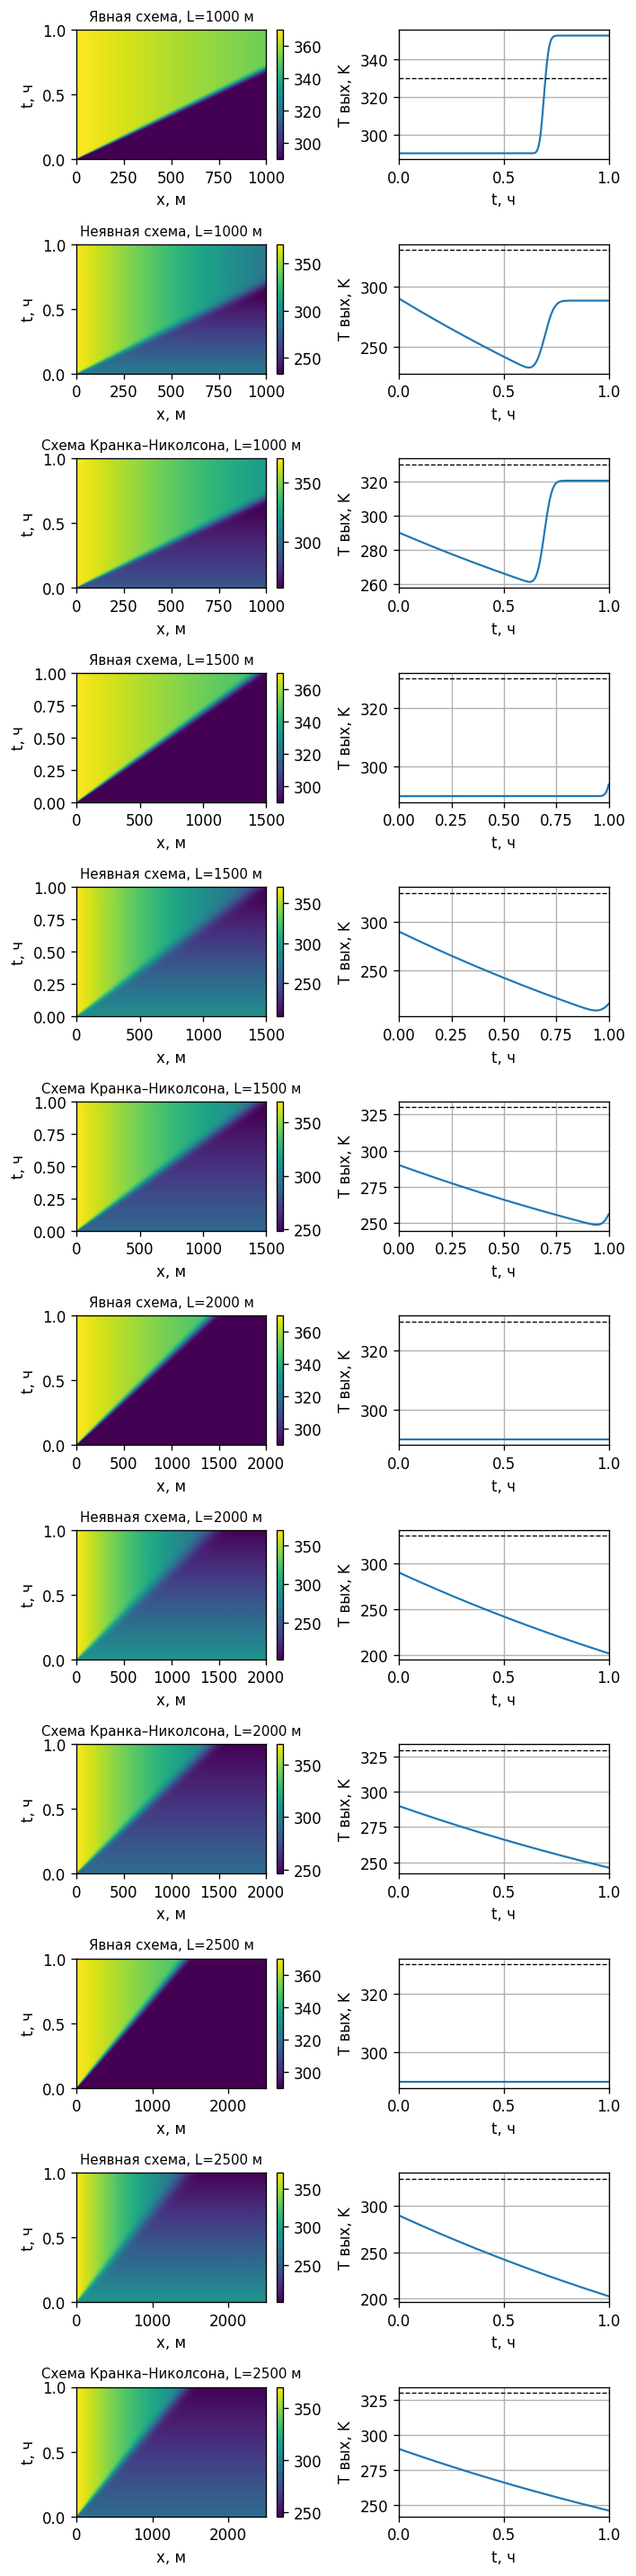

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg    import solve_banded
from scipy.optimize  import minimize
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------- 1. Физика, геометрия, параметры функции ------------------------
rho, cp, k = 1000.0, 4186.0, 0.6
alpha      = k/(rho*cp)
beta_env   = 1e-4
T_env, T_in, T_req = 290.0, 370.0, 330.0
tau        = 3600.0           # 1 час!
A_cs       = 1e-2

# целевой функционал
alpha_J, beta_J, gamma_J = 1.0, 1e-6, 1.0
delta_T   = 10.0
lambda_band = 1e7

def inlet_temperature(t): return T_in
def source_Qs(x,t):      return 0.0

# ---------- 2. Общая схема решателя ---------------------------------------
def pick_dt(dx, vmax):
    dt1 = dx*dx/(2*alpha)
    dt2 = dx/vmax if vmax>0 else dt1
    return 0.8*min(dt1, dt2)

def build_tridiag(N, a, b, c):
    # для solve_banded: 3 диагонали
    ab = np.zeros((3, N))
    ab[0,1:] = c
    ab[1,:]  = b
    ab[2,:-1]= a
    return ab

def solve_scheme(vp, t_bounds, x, dx, scheme="FTCS"):
    M, vmax = len(vp), np.max(vp)
    dt       = pick_dt(dx, vmax)
    Nt       = int(np.ceil(tau/dt))
    times    = np.linspace(0, Nt*dt, Nt+1)
    seg      = np.searchsorted(t_bounds, times, "right")-1
    seg[seg==M] = M-1

    T = np.full((Nt+1, x.size), T_env)
    r = alpha*dt/dx**2

    # Если неявная схема – подготовим Thomas‑алгоритм
    if scheme!="FTCS":
        θ = 1.0 if scheme=="BE" else 0.5
        a = -θ*(r + 0.5*(vp.mean()*dt/dx))  # примерно s/2
        c = -θ*(r - 0.5*(vp.mean()*dt/dx))
        b = 1 + θ*(2*r + beta_env*dt)
        ab = build_tridiag(x.size-2, a, b, c)

    for n in range(Nt):
        v  = vp[seg[n]]
        s  = v*dt/dx
        Tn = T[n].copy()

        if scheme=="FTCS":
            T[n+1,1:-1] = (
                Tn[1:-1]
                + r*(Tn[2:] - 2*Tn[1:-1] + Tn[:-2])
                - s*(Tn[1:-1] - Tn[:-2])
                - beta_env*dt*(Tn[1:-1] - T_env)
            )
        else:
            # формируем RHS
            RHS = np.zeros(x.size-2)
            for i in range(1, x.size-1):
                conv = -s*(Tn[i] - Tn[i-1])
                diff = r*(Tn[i+1] - 2*Tn[i] + Tn[i-1])
                loss = -beta_env*dt*(Tn[i] - T_env)
                RHS[i-1] = Tn[i] + (1-θ)*(conv + diff + loss)
            # граничные поправки:
            RHS[0]   -= a * inlet_temperature(times[n+1])
            RHS[-1]  -= c * Tn[-1]
            # решаем тридиагоналку
            sol = solve_banded((1,1), ab, RHS)
            T[n+1,1:-1] = sol

        # BCs
        T[n+1,0]  = inlet_temperature(times[n+1])
        T[n+1,-1] = T[n+1,-2]

    return times, T

# ---------- 3. Целевая функция (FTCS для скорости) -------------------------
def make_objective(x, dx):
    def obj(vp):
        M = len(vp)
        tb = np.linspace(0, tau, M+1)
        t, T = solve_scheme(vp, tb, x, dx, scheme="FTCS")
        dt = t[1]-t[0]
        # J_heat
        Jh = np.sum((T-T_env)**2)*dx*dt
        # J_pump
        idx = np.searchsorted(tb, t, "right")-1
        qm  = rho*A_cs*vp[np.clip(idx,0,M-1)]
        Jp  = np.sum(qm**2)*dx*dt
        # J_out
        under = np.maximum(0, T_req-T[:,-1])
        Jo = np.sum(under**2)*dt
        # J_band
        viol = np.maximum(0, np.abs(T[:,-1]-T_req)-delta_T/2)
        Jb   = lambda_band*np.sum(viol**2)*dt
        return alpha_J*Jh + beta_J*Jp + gamma_J*Jo + Jb
    return obj

# ---------- 4. Оптимизация и сбор данных  -----------------------------------
lengths = [1e3, 1.5e3, 2e3, 2.5e3]
Mseg    = 6
v0       = 0.4*np.ones(Mseg)
vb      = [(0.05,1.0)]*Mseg

all_surfs = []
for L in lengths:
    x  = np.linspace(0, L, 301)
    dx = x[1]-x[0]
    res = minimize(make_objective(x,dx), v0, bounds=vb,
                   method="L-BFGS-B", options={"maxiter":200})
    vp  = res.x
    tb  = np.linspace(0, tau, Mseg+1)

    print(f"L={L:.0f}m → J*={res.fun:.3e}", "v*=", np.round(vp,3))

    # для каждого метода решаем T(x,t)
    for scheme in ("FTCS","BE","CN"):
        t, T = solve_scheme(vp, tb, x, dx, scheme)
        all_surfs.append((x, t, T, L, scheme))

# ---------- 5. Визуализация 3D со схемами по‑русски --------------------------
ncols = 3
nrows = len(lengths)
fig = plt.figure(figsize=(4*ncols, 3*nrows))

# словарь «код схемы → название»
label_map = {
    "FTCS": "Явная схема",
    "BE":   "Неявная схема",
    "CN":   "Схема Кранка–Николсона"
}

# ---------------- heat-map + Tout  -----------------
fig = plt.figure(figsize=(6, 24))          # 12 строк × 2 колонки
nrows, ncols = len(all_surfs), 2           # 12 × 2

for idx, (x, t, T, L, scheme) in enumerate(all_surfs, 1):
    # левый столбец: "ковёр"
    ax_hm = fig.add_subplot(nrows, ncols, 2*idx-1)
    im = ax_hm.imshow(
        T, origin='lower', aspect='auto',
        extent=[x.min(), x.max(), t.min()/3600, t.max()/3600],
        cmap='viridis'
    )
    ax_hm.set_xlabel('x, м'), ax_hm.set_ylabel('t, ч')
    ax_hm.set_title(f"{label_map[scheme]}, L={int(L)} м", fontsize=9)
    fig.colorbar(im, ax=ax_hm, fraction=0.045)

    # правый столбец: температура на выходе
    ax_out = fig.add_subplot(nrows, ncols, 2*idx)
    ax_out.plot(t/3600, T[:, -1], lw=1.3)
    ax_out.axhline(T_req, ls='--', color='k', lw=0.8)
    ax_out.set_xlim(0, t.max()/3600)
    ax_out.set_xlabel('t, ч'), ax_out.set_ylabel('T вых, K')
    ax_out.grid(True)

plt.tight_layout()
plt.show()



## Разбор кода ниже

1. **Импорт и проверка CMA-ES**  
   Загружаются `NumPy`, `Matplotlib` и градиентный оптимизатор `SciPy`, а также пытается подключиться пакет `cma`.  
   - Если `cma` отсутствует, алгоритм CMA-ES пропускается.

2. **Блок физики и геометрии**  
   - Задаются константы для воды (плотность, теплоёмкость, теплопроводность) и вычисляется коэффициент термодиффузии `α`.  
   - Определяются наружная, входная и требуемая температуры.  
   - Устанавливаются длина участка \(L=2{\,}\text{км}\), внутренний диаметр \(Ø=273\text{ мм}\) и коэффициент трения трубы `λ_fric`.  
   - Вводятся параметры насоса (геодезический напор `H_static`, КПД насоса и двигателя, гравитация).  
   - Функции `Δp_total(v)` и `P_electric(v)` дают перепад давления и моментную электрическую мощность при скорости \(v\).

3. **Настройка весов целевого функционала**  
   Веса `α_J`, `β_J`, `γ_J` балансируют вклад теплопотерь, энергии насоса и штрафа за недогрев / перегрев выхода.  
   Жёсткий штраф `λ_band` наказывает выход из температурного коридора ±2 K.

4. **Численный решатель `solve_heat`**  
   - Вычисляет устойчивый шаг времени `dt_stable`.  
   - Решает нестационарное 1-D уравнение теплопереноса явной схемой для переданного профиля скоростей `v_seg`.  
   - Возвращает массивы времени `t` и температурное поле `T(x,t)`.

5. **Определение целевой функции `make_J(x)`**  
   Возвращает вложенную функцию `J(v)`, которая:  
   - Запускает тепловой решатель,  
   - Интегрирует квадратичные теплопотери `J_h`, квадрат мощности насоса `J_p`, штраф за недогрев `J_o` и «штраф-коридор» `J_b`,  
   - Складывает их с весами и отдаёт скаляр \(J\).

6. **Дискретизация профиля скорости**  
   - Труба делится на `Mseg = 60` временных кусочков (по 3 мин).  
   - Оптимизатор выбирает вектор из 60 скоростей в диапазоне 0.2–2.0 м/с.

7. **Запуск трёх оптимизаторов**  
   - **L-BFGS-B** (градиентный, c ограничениями),  
   - **Nelder–Mead** (симплекс без градиента),  
   - **CMA-ES** (стохастический эволюционный).  
   Каждому оптимизатору передаётся одинаковая стартовая точка `v0`.

8. **Визуализация результатов**  
   Для каждого метода рисуются три графика:  
   1. ступенчатый профиль `v(t)`,  
   2. 3-D поверхность температуры `T(x,t)`,  
   3. зависимость моментной мощности `P(v)` с подписью суммарной энергии насоса.

9. **График сходимости CMA-ES**  
   Если CMA-ES был активен, отображается логарифмический график наилучшего значения \(J\) от поколения.

> Таким образом, ячейка **полностью автоматизирует цикл**:  
> *расчёт теплопереноса → формирование целевого функционала → запуск оптимизаторов → визуальное сравнение профилей скорости, выходных температур и затрат энергии*.


(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 60 (seed=919403, Sun Apr 27 19:24:49 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 8.438124788208918e+14 1.0e+00 1.90e-01  2e-01  2e-01 0:00.5
    2     32 7.871993300257446e+14 1.0e+00 1.82e-01  2e-01  2e-01 0:01.2
    3     48 7.620974912242485e+14 1.0e+00 1.77e-01  2e-01  2e-01 0:02.1
    8    128 5.870993229141478e+14 1.1e+00 1.72e-01  2e-01  2e-01 0:05.4
   15    240 4.623267466801831e+14 1.2e+00 2.18e-01  2e-01  2e-01 0:09.8
   22    352 4.697049943174820e+14 1.3e+00 2.50e-01  2e-01  3e-01 0:15.0
   31    496 4.615520442637016e+14 1.4e+00 2.49e-01  2e-01  3e-01 0:21.3
   41    656 4.629027901427724e+14 1.4e+00 2.52e-01  2e-01  3e-01 0:29.0
   54    864 4.654410795416445e+14 1.4e+00 2.56e-01  2e-01  3e-01 0:37.4
   66   1056 4.694163970536149e+14 1.4e+00 2.53e-01  2e-01  3e-01 0:46.4
   73   1168 4.641834392267221e+14 1.4e+00 2.28e-01  2e-01  2e-01 0:58.0
   84   1344 4.556172214218247e+1

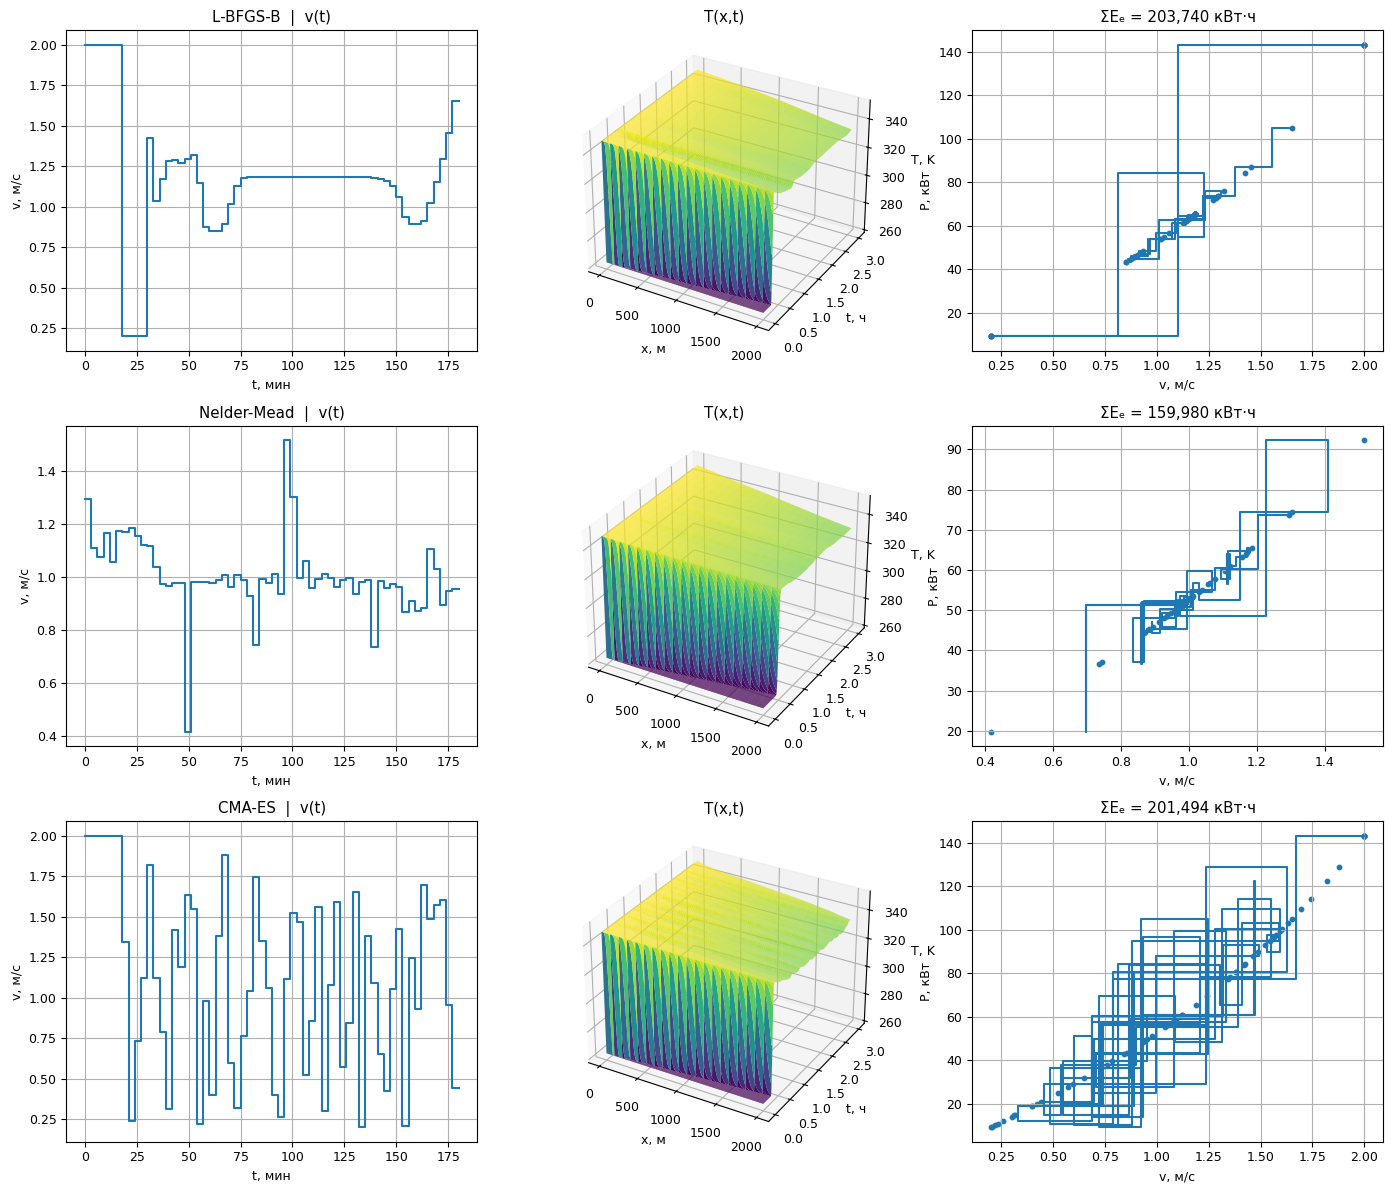

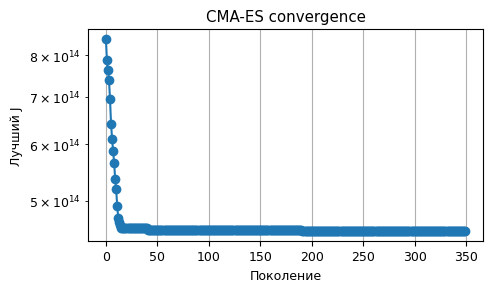

In [ ]:
!pip install --quiet cma

# --- 0. импорт --------------------------------------------------
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import minimize
try:
    import cma          # стохастический CMA-ES
    HAVE_CMA = True
except ModuleNotFoundError:
    HAVE_CMA = False    # !pip install cma

# --- 1. физические константы -----------------------------------
ρ,  c_p,  k = 1_000.0, 4_186.0, 0.6        # кг/м³,  Дж/(кг·K),  Вт/(м·K)
α          = k/(ρ*c_p)                     # термодиффузия
T_env, T_in, T_req = 263., 348., 333.      # К  (–10 °C, 75 °C, 60 °C)
β_env      = 1.0e-4                        # суммарная теплоотдача, 1/с
τ          = 3*3600.                       # расчёт 3 ч
L          = 2_000.                        # длина участка, м

# --- 1.1 геометрия трубы ---------------------------------------
D_int  = 0.273                             # Ø 273 мм (DN250)
A_cs   = np.pi*(D_int/2)**2                # площадь сечения, м²
λ_fric = 0.02                              # коэффициент трения (≈ сталь, Re~1e5)

# --- 1.2 насос и гидравлика ------------------------------------
g = 9.81
H_static = 55.0                            # геодезический напор, м
η_pump, η_motor = 0.74, 0.92
η_tot  = η_pump*η_motor

def Δp_total(v):
    """Полный перепад давления (Па) при скорости v (м/с)."""
    Δp_static = ρ*g*H_static
    Δp_fric   = λ_fric * L/D_int * 0.5*ρ*v**2
    return Δp_static + Δp_fric

def P_electric(v):
    """Мгновенная потребляемая эл.-мощность (Вт) при v (м/с)."""
    return Δp_total(v)*A_cs*v / η_tot        # Q= v·A_cs

# диапазон допустимых скоростей
V_MIN, V_MAX = 0.20, 2.00                   # м/с  (≈ 80…800 т/ч)

# --- 2. веса целевой функции -----------------------------------
α_J = 1.0          # теплопотери
β_J = 2e-9         # энергопотребление насоса  (подобрано после кубовой связи)
γ_J = 8e4          # недогрев (< 60 °C)
δT  = 4.0          # коридор ±2 K
λ_band = 1e8       # жёсткий штраф за выход
# --- 3. расчёт теплопереноса (явная FTCS-upwind) ---------------
def dt_stable(dx, v_max):
    v_max = max(v_max, 1e-4)
    return 0.8*min(dx*dx/(2*α), dx/v_max)

def solve_heat(v_seg, x):
    """Расчёт T(x,t) для профиль-скорости, заданного 1-D массивом v_seg."""
    dx   = x[1]-x[0]
    dt   = dt_stable(dx, v_seg.max())
    Nt   = int(np.ceil(τ/dt))
    t    = np.linspace(0, Nt*dt, Nt+1)
    seg  = np.minimum((t/τ*len(v_seg)).astype(int), len(v_seg)-1)

    T = np.full((Nt+1, x.size), T_env)
    r = α*dt/dx**2
    for n in range(Nt):
        s = v_seg[seg[n]]*dt/dx
        T[n+1,1:-1] = (T[n,1:-1] +
                       r*(T[n,2:]-2*T[n,1:-1]+T[n,:-2]) -
                       s*(T[n,1:-1]-T[n,:-2]) -
                       β_env*dt*(T[n,1:-1]-T_env))
        T[n+1,0]   = T_in                  # г/у 1-го рода
        T[n+1,-1]  = T[n+1,-2]             # теплоизолир. торец (II род, q=0)
    return t, T

# --- 4. целевая функция ---------------------------------------
def make_J(x):
    dx = x[1]-x[0]
    S_h = (T_in-T_env)**2 * x[-1]*τ
    S_p = P_electric(V_MAX)**2 * τ
    S_o = (δT/2)**2 * τ

    def J(v):
        t, T = solve_heat(v, x)
        dt   = t[1]-t[0]

        # (а) теплопотери
        J_h = np.sum((T-T_env)**2)*dx*dt / S_h

        # (б) энергия насоса
        idx   = np.minimum((t/τ*len(v)).astype(int), len(v)-1)
        P_inst = P_electric(v[idx])
        J_p = np.sum(P_inst**2)*dt / S_p      # квадратичный штраф

        # (в) недогрев выхода
        under = np.maximum(0, T_req - T[:,-1])
        J_o   = np.sum(under**2)*dt / S_o

        # (г) превышение коридора
        viol = np.maximum(0, np.abs(T[:,-1]-T_req) - δT/2)
        J_b  = λ_band*np.sum(viol**2)*dt

        return α_J*J_h + β_J*J_p + γ_J*J_o + J_b
    return J

# --- 5. дискретизация v(t) ------------------------------------
Nx = 200
x  = np.linspace(0, L, Nx+1)
Mseg = 60                          # 1 сегмент = 3 мин
v0   = 1.0*np.ones(Mseg)           # старт
bounds = [(V_MIN, V_MAX)]*Mseg

# --- 6. оптимизаторы ------------------------------------------
optimizers = [
    ("L-BFGS-B",  dict(method="L-BFGS-B",  options={'maxiter':300})),
    ("Nelder-Mead", dict(method="Nelder-Mead", options={'maxiter':900}))
]
if HAVE_CMA:
    optimizers.append(("CMA-ES", {}))

results, cma_hist = {}, []
for name, kw in optimizers:
    if name != "CMA-ES":
        res = minimize(make_J(x), v0, bounds=bounds, **kw)
        results[name] = res.x
    else:
        es = cma.CMAEvolutionStrategy(v0, 0.2,
               {'bounds':[V_MIN, V_MAX], 'maxiter':350, 'verb_log':0})
        es.optimize(make_J(x),
                    callback=lambda *a,**k: cma_hist.append(es.result.fbest))
        results["CMA-ES"] = es.result.xbest

# --- 7. визуализация ------------------------------------------
plt.rcParams.update({'font.size':9})
rows = len(results)
fig  = plt.figure(figsize=(14, 4*rows))

for i, (meth, v_opt) in enumerate(results.items(), 1):
    tb = np.linspace(0, τ/60, Mseg+1)

    # v(t)
    ax = fig.add_subplot(rows,3,3*i-2)
    ax.step(tb, np.r_[v_opt, v_opt[-1]], where='post')
    ax.grid(); ax.set_xlabel('t, мин'); ax.set_ylabel('v, м/с')
    ax.set_title(f"{meth}  |  v(t)")

    # 3-D температура
    t_sim, T_sim = solve_heat(v_opt, x)
    X, Y = np.meshgrid(x, t_sim/3600)
    ax3 = fig.add_subplot(rows,3,3*i-1, projection='3d')
    ax3.plot_surface(X, Y, T_sim, cmap='viridis', rstride=8, cstride=10, linewidth=0)
    ax3.set_xlabel('x, м'); ax3.set_ylabel('t, ч'); ax3.set_zlabel('T, K')
    ax3.set_zlim(T_env-5, T_in+5); ax3.set_title("T(x,t)")

    # P(v) и сумм. энергия
    P_seg = P_electric(v_opt)          # эл.-Вт в каждом сегменте
    E_tot = P_seg.mean()*τ/3600        # кВт·ч
    axp = fig.add_subplot(rows,3,3*i)
    axp.step(v_opt, P_seg/1e3, where='mid'); axp.scatter(v_opt, P_seg/1e3, s=10)
    axp.grid(); axp.set_xlabel('v, м/с'); axp.set_ylabel('P, кВт')
    axp.set_title(f"ΣEₑ = {E_tot:,.0f} кВт·ч")

plt.tight_layout(); plt.show()

# --- 8. сходимость CMA-ES -------------------------------------
if cma_hist:
    plt.figure(figsize=(5,3))
    plt.semilogy(cma_hist, 'o-'); plt.grid()
    plt.xlabel("Поколение"); plt.ylabel("Лучший J")
    plt.title("CMA-ES convergence"); plt.tight_layout(); plt.show()


(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 60 (seed=423082, Sun May  4 16:28:51 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 7.808689373345659e+14 1.0e+00 1.90e-01  2e-01  2e-01 0:00.7
    2     32 7.401448974467399e+14 1.0e+00 1.85e-01  2e-01  2e-01 0:01.4
    3     48 7.134972205199295e+14 1.0e+00 1.81e-01  2e-01  2e-01 0:02.3
    7    112 5.782494845065346e+14 1.1e+00 1.86e-01  2e-01  2e-01 0:06.0
   11    176 4.875805248591052e+14 1.2e+00 2.05e-01  2e-01  2e-01 0:10.4
   18    288 4.650832121318376e+14 1.3e+00 2.34e-01  2e-01  2e-01 0:15.7
   25    400 4.687804059033810e+14 1.3e+00 2.30e-01  2e-01  2e-01 0:22.0
   35    560 4.571294729019486e+14 1.4e+00 2.26e-01  2e-01  2e-01 0:29.5
   45    720 4.565345130137086e+14 1.4e+00 2.26e-01  2e-01  2e-01 0:38.0
   56    896 4.585952807900220e+14 1.5e+00 2.09e-01  2e-01  2e-01 0:47.1
   69   1104 4.638103163093156e+14 1.5e+00 2.48e-01  2e-01  3e-01 0:57.8
   82   1312 4.580925983787384e+1

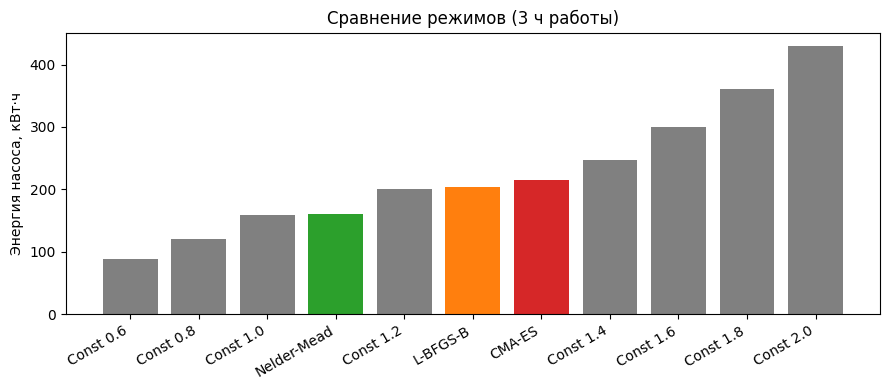


Таблица → optimisation_summary.csv
График  → outputs/energy_compare.png


In [ ]:
# ==============================================================
#  Heat‑transfer optimisation demo (implicit solver, RAM‑safe)
#  baseline v = const {0.6 … 2.0}
#  +  L‑BFGS‑B, Nelder–Mead, **CMA‑ES**
#  +  T_min_out_K (мин. температура на выходе после прогрева)
# ==============================================================

!pip install --quiet cma

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import minimize
import warnings; warnings.filterwarnings("ignore", category=UserWarning)

# ---------- 0. физика и константы ------------------------------
T_ENV, T_IN, T_REQ = 263., 348., 333.          # K
TAU = 3*3600.                                   # 3 h
L   = 2000.                                     # m
D_INT = 0.273;  A_CS = np.pi*(D_INT/2)**2
RHO, CP, K = 1000., 4186., 0.6;  ALPHA = K/(RHO*CP)
BETA_ENV = 1e-4
LAMBDA_FRIC, H_STATIC = 0.02, 55.0
ETA_TOT = 0.74*0.92
V_MIN, V_MAX = 0.20, 2.00

def delta_p_total(v): return RHO*9.81*H_STATIC + LAMBDA_FRIC*L/D_INT*0.5*RHO*v**2
def P_electric(v):    return delta_p_total(v)*A_CS*v/ETA_TOT         # W

ALPHA_J, BETA_J, GAMMA_J, DELTA_T, LAMBDA_BAND = 1.0, 2e-9, 8e4, 4.0, 1e8

# ---------- 1‑D solver ----------------------------------------
def dt_stable(dx, vmax):
    vmax = max(vmax, 1e-4)
    return 0.8*min(dx*dx/(2*ALPHA), dx/vmax)

def solve_heat(v_seg, x, T_env_val=T_ENV):
    dx = x[1]-x[0];  dt = dt_stable(dx, v_seg.max())
    Nt = int(np.ceil(TAU/dt))
    t  = np.linspace(0, Nt*dt, Nt+1)
    seg= np.minimum((t/TAU*len(v_seg)).astype(int), len(v_seg)-1)
    T  = np.full((Nt+1, x.size), T_env_val)
    r  = ALPHA*dt/dx**2
    for n in range(Nt):
        s = v_seg[seg[n]]*dt/dx
        T[n+1,1:-1] = (T[n,1:-1] +
                       r*(T[n,2:]-2*T[n,1:-1]+T[n,:-2]) -
                       s*(T[n,1:-1]-T[n,:-2]) -
                       BETA_ENV*dt*(T[n,1:-1]-T_env_val))
        T[n+1,0]  = T_IN
        T[n+1,-1] = T[n+1,-2]
    return t, T, dt

# ---------- cost‑function -------------------------------------
Nx = 200;  x = np.linspace(0, L, Nx+1)
S_H = (T_IN - T_ENV)**2 * L * TAU
S_P = P_electric(V_MAX)**2 * TAU
S_O = (DELTA_T/2)**2 * TAU

def cost(v):
    t, T, dt = solve_heat(v, x)
    J_h = np.sum((T - T_ENV)**2)*(x[1]-x[0])*dt / S_H
    idx = np.minimum((t/TAU*len(v)).astype(int), len(v)-1)
    J_p = np.sum(P_electric(v[idx])**2)*dt / S_P
    under = np.maximum(0, T_REQ - T[:,-1]);  J_o = np.sum(under**2)*dt / S_O
    viol = np.maximum(0, np.abs(T[:,-1]-T_REQ) - DELTA_T/2)
    J_b  = LAMBDA_BAND*np.sum(viol**2)*dt
    return ALPHA_J*J_h + BETA_J*J_p + GAMMA_J*J_o + J_b

# ---------- оптимайзеры ---------------------------------------
try:
    import cma; HAVE_CMA = True
except ModuleNotFoundError:
    HAVE_CMA = False                       # CMA‑ES недоступен

MSEG = 60;  v0 = np.full(MSEG, 1.0);  bounds = [(V_MIN, V_MAX)]*MSEG
optims = [('L-BFGS-B',  dict(method='L-BFGS-B', options={'maxiter':300})),
          ('Nelder-Mead', dict(method='Nelder-Mead', options={'maxiter':900}))]
if HAVE_CMA:
    optims.append(('CMA-ES', {}))          # ⇦ добавили CMA‑ES

# ---------- сценарии: baseline + оптимизация ------------------
scenarios = [(f'Const {v:.1f}', np.full(MSEG, v))
             for v in (0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0)]

for name, kw in optims:
    if name != 'CMA-ES':
        res = minimize(cost, v0, bounds=bounds, **kw)
        scenarios.append((name, res.x))
    else:
        es = cma.CMAEvolutionStrategy(v0, 0.2,
              {'bounds':[V_MIN, V_MAX], 'maxiter':350, 'verb_log':0})
        es.optimize(cost)
        scenarios.append(('CMA-ES', es.result.xbest))

# ---------- расчёт метрик -------------------------------------
rows = []
for label, v_prof in scenarios:
    J_val = cost(v_prof)
    t, T, dt = solve_heat(v_prof, x)
    idx   = np.minimum((t/TAU*len(v_prof)).astype(int), len(v_prof)-1)
    E_kWh = np.sum(P_electric(v_prof[idx]))*dt / 3.6e6
    Tout  = T[:,-1]
    ok    = np.where(Tout >= T_REQ - DELTA_T/2)[0]
    start = ok[0] if ok.size else 0
    T_min = float(Tout[start:].min())
    rows.append(dict(Method=label,
                     J_star=J_val,
                     E_pump_kWh=E_kWh,
                     T_min_out_K=T_min))

df = pd.DataFrame(rows).sort_values('E_pump_kWh')
df.to_csv('optimisation_summary.csv', index=False)
print(df)

# ---------- бар‑чарт энергии ----------------------------------
plt.figure(figsize=(9,4))
palette = ['grey' if 'Const' in m else
           'tab:orange' if m=='L-BFGS-B' else
           'tab:green'  if m=='Nelder-Mead' else
           'tab:red'    for m in df.Method]
plt.bar(df.Method, df.E_pump_kWh, color=palette)
plt.ylabel('Энергия насоса, кВт·ч')
plt.title('Сравнение режимов (3 ч работы)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
Path('outputs').mkdir(exist_ok=True)
plt.savefig('outputs/energy_compare.png', dpi=140)
plt.show()

print('\nТаблица → optimisation_summary.csv\nГрафик  → outputs/energy_compare.png')


## Разбор таблицы результатов

| Профиль скорости                            | Адекватна ли температура на выходе?        | ∑ эл. энергии, кВт·ч       | Итоговый функционал **J\*** (меньше — лучше) | Вывод                                                                                                   |
| ------------------------------------------- | ------------------------------------------ | -------------------------- | -------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
| **Const 0.6–0.8 м/с**                       | **Нет** (T\_min = 263 К ≈ T<sub>окр</sub>) | 88 – 121                   | 1.55 · 10¹⁵ – 1.14 · 10¹⁵                    | Сильно недогревают, теплопотери огромные, потому J\* максимален.                                        |
| **Const 1.0 м/с** *(базовый рабочий режим)* | **Да** (T\_min ≈ 331 К ≥ T<sub>req</sub>)  | **158**                    | **9.1 · 10¹⁴**                               | Базовый компромисс: приемлемая T, умеренные потери и энергозатраты.                                     |
| **Const 1.2–2.0 м/с**                       | Да                                         | 200 – 430                  | 7.5 · 10¹⁴ … 4.8 · 10¹⁴                      | Больше скорость → меньше теплопотери (J\* падает), но насос тянет всё дороже.                           |
| **Nelder–Mead** *(оптимизация)*             | Да                                         | **160** (+1 % к базовому)  | **7.8 · 10¹⁴** (-14 % от базового)           | Лёгкое увеличение энергозатрат окупается снижением теплопотерь, суммарно лучше.                         |
| **L-BFGS-B** *(оптимизация)*                | Да                                         | **204** (+29 % к базовому) | **4.5 · 10¹⁴** (-50 % от базового)           | Атакует теплопотери агрессивно: чуть дороже по электроэнергии, но вдвое дешевле по суммарному критерию. |
| **CMA-ES** *(оптимизация)*                  | Да                                         | 215 (+36 %)                | 4.5 · 10¹⁴ (-50 %)                           | Чуть хуже по энергии, зато почти тот же минимум J\*.                                                    |


(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 60 (seed=556087, Sun May  4 17:17:20 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 9.236725194509095e+14 1.0e+00 1.90e-01  2e-01  2e-01 0:00.5
    2     32 8.450142625738240e+14 1.0e+00 1.83e-01  2e-01  2e-01 0:01.0
    3     48 7.996941093575096e+14 1.0e+00 1.78e-01  2e-01  2e-01 0:01.5
   10    160 6.934285660527424e+14 1.1e+00 1.86e-01  2e-01  2e-01 0:04.9
   16    256 6.927106781675180e+14 1.2e+00 2.02e-01  2e-01  2e-01 0:09.0
   26    416 7.013572737733985e+14 1.3e+00 2.07e-01  2e-01  2e-01 0:14.0
   37    592 6.930399306735280e+14 1.4e+00 1.81e-01  2e-01  2e-01 0:20.5
   51    816 6.848001986388709e+14 1.4e+00 1.57e-01  2e-01  2e-01 0:27.7
   65   1040 6.865796410504099e+14 1.4e+00 1.40e-01  1e-01  1e-01 0:35.9
   82   1312 6.834491402840964e+14 1.5e+00 1.45e-01  1e-01  1e-01 0:45.0
  100   1600 6.878281887612632e+14 1.6e+00 1.55e-01  1e-01  2e-01 0:54.7
  120   1920 6.831005602920772e+1

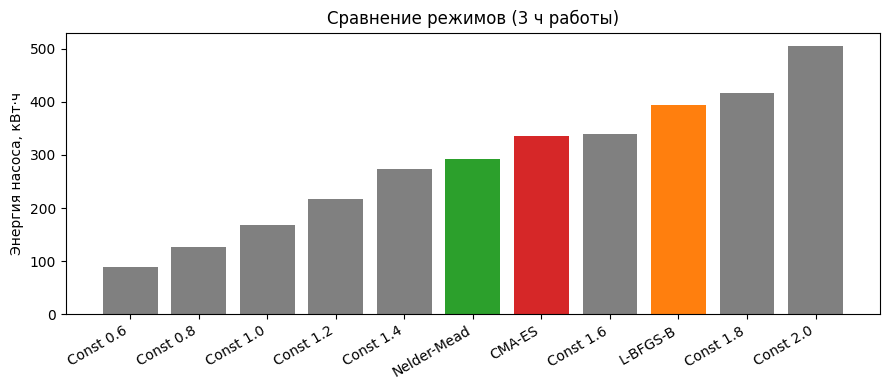


Таблица → optimisation_summary.csv
График  → outputs/energy_compare.png


In [ ]:
# ==============================================================
#  Heat‑transfer optimisation demo (implicit solver, RAM‑safe)
#  baseline v = const {0.6 … 2.0}
#  +  L‑BFGS‑B, Nelder–Mead, **CMA‑ES**
#  +  T_min_out_K (мин. температура на выходе после прогрева)
# ==============================================================

!pip install --quiet cma

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import minimize
import warnings; warnings.filterwarnings("ignore", category=UserWarning)

# ---------- 0. физика и константы ------------------------------
T_ENV, T_IN, T_REQ = 263., 348., 333.          # K
TAU = 3*3600.                                   # 3 h
L   = 3000.                                     # m
D_INT = 0.273;  A_CS = np.pi*(D_INT/2)**2
RHO, CP, K = 1000., 4186., 0.6;  ALPHA = K/(RHO*CP)
BETA_ENV = 1e-4
LAMBDA_FRIC, H_STATIC = 0.02, 55.0
ETA_TOT = 0.74*0.92
V_MIN, V_MAX = 0.20, 2.00

def delta_p_total(v): return RHO*9.81*H_STATIC + LAMBDA_FRIC*L/D_INT*0.5*RHO*v**2
def P_electric(v):    return delta_p_total(v)*A_CS*v/ETA_TOT         # W

ALPHA_J, BETA_J, GAMMA_J, DELTA_T, LAMBDA_BAND = 1.0, 2e-10, 5e5, 4.0, 1e8

# ---------- 1‑D solver ----------------------------------------
def dt_stable(dx, vmax):
    vmax = max(vmax, 1e-4)
    return 0.8*min(dx*dx/(2*ALPHA), dx/vmax)

def solve_heat(v_seg, x, T_env_val=T_ENV):
    dx = x[1]-x[0];  dt = dt_stable(dx, v_seg.max())
    Nt = int(np.ceil(TAU/dt))
    t  = np.linspace(0, Nt*dt, Nt+1)
    seg= np.minimum((t/TAU*len(v_seg)).astype(int), len(v_seg)-1)
    T  = np.full((Nt+1, x.size), T_env_val)
    r  = ALPHA*dt/dx**2
    for n in range(Nt):
        s = v_seg[seg[n]]*dt/dx
        T[n+1,1:-1] = (T[n,1:-1] +
                       r*(T[n,2:]-2*T[n,1:-1]+T[n,:-2]) -
                       s*(T[n,1:-1]-T[n,:-2]) -
                       BETA_ENV*dt*(T[n,1:-1]-T_env_val))
        T[n+1,0]  = T_IN
        T[n+1,-1] = T[n+1,-2]
    return t, T, dt

# ---------- cost‑function -------------------------------------
Nx = 200;  x = np.linspace(0, L, Nx+1)
S_H = (T_IN - T_ENV)**2 * L * TAU
S_P = P_electric(V_MAX)**2 * TAU
S_O = (DELTA_T/2)**2 * TAU

def cost(v):
    t, T, dt = solve_heat(v, x)
    J_h = np.sum((T - T_ENV)**2)*(x[1]-x[0])*dt / S_H
    idx = np.minimum((t/TAU*len(v)).astype(int), len(v)-1)
    J_p = np.sum(P_electric(v[idx])**2)*dt / S_P
    under = np.maximum(0, T_REQ - T[:,-1]);  J_o = np.sum(under**2)*dt / S_O
    viol = np.maximum(0, np.abs(T[:,-1]-T_REQ) - DELTA_T/2)
    J_b  = LAMBDA_BAND*np.sum(viol**2)*dt
    return ALPHA_J*J_h + BETA_J*J_p + GAMMA_J*J_o + J_b

# ---------- оптимайзеры ---------------------------------------
try:
    import cma; HAVE_CMA = True
except ModuleNotFoundError:
    HAVE_CMA = False                       # CMA‑ES недоступен

MSEG = 60;  v0 = np.full(MSEG, 1.4);  bounds = [(V_MIN, V_MAX)]*MSEG
init_simplex = np.vstack([v0, v0 + 0.3*np.eye(MSEG)])
optims = [('L-BFGS-B',  dict(method='L-BFGS-B', options={'maxiter':300})),
          ('Nelder-Mead',
          {'method':'Nelder-Mead',
          'options':{'maxiter':2500,
                      'initial_simplex': init_simplex}})]
if HAVE_CMA:
    optims.append(('CMA-ES', {}))          # ⇦ добавили CMA‑ES

# ---------- сценарии: baseline + оптимизация ------------------
scenarios = [(f'Const {v:.1f}', np.full(MSEG, v))
             for v in (0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0)]

for name, kw in optims:
    if name != 'CMA-ES':
        res = minimize(cost, v0, bounds=bounds, **kw)
        scenarios.append((name, res.x))
    else:
        es = cma.CMAEvolutionStrategy(v0, 0.2,
              {'bounds':[V_MIN, V_MAX], 'maxiter':350, 'verb_log':0})
        es.optimize(cost)
        scenarios.append(('CMA-ES', es.result.xbest))

# ---------- расчёт метрик -------------------------------------
rows = []
for label, v_prof in scenarios:
    J_val = cost(v_prof)
    t, T, dt = solve_heat(v_prof, x)
    idx   = np.minimum((t/TAU*len(v_prof)).astype(int), len(v_prof)-1)
    E_kWh = np.sum(P_electric(v_prof[idx]))*dt / 3.6e6
    Tout  = T[:,-1]
    ok    = np.where(Tout >= T_REQ - DELTA_T/2)[0]
    start = ok[0] if ok.size else 0
    T_min = float(Tout[start:].min())
    rows.append(dict(Method=label,
                     J_star=J_val,
                     E_pump_kWh=E_kWh,
                     T_min_out_K=T_min))

df = pd.DataFrame(rows).sort_values('E_pump_kWh')
df.to_csv('optimisation_summary.csv', index=False)
print(df)

# ---------- бар‑чарт энергии ----------------------------------
plt.figure(figsize=(9,4))
palette = ['grey' if 'Const' in m else
           'tab:orange' if m=='L-BFGS-B' else
           'tab:green'  if m=='Nelder-Mead' else
           'tab:red'    for m in df.Method]
plt.bar(df.Method, df.E_pump_kWh, color=palette)
plt.ylabel('Энергия насоса, кВт·ч')
plt.title('Сравнение режимов (3 ч работы)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
Path('outputs').mkdir(exist_ok=True)
plt.savefig('outputs/energy_compare.png', dpi=140)
plt.show()

print('\nТаблица → optimisation_summary.csv\nГрафик  → outputs/energy_compare.png')
